# Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

# [1]. Reading Data

## [1.1] Loading the data


In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
from tqdm import tqdm
import os
print()

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [13]:
reviewDF = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
reviewDF = reviewDF[:-50000]

In [14]:
# Saving dataframe to make sure we are processing same dataset(Train, Test, Cv) across various models.
reviewDF.to_pickle('reviewDF')

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [2]:
reviewDF = pd.read_pickle('reviewDF')

In [3]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [4]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [5]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(reviewDF['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 314171/314171 [01:26<00:00, 3631.02it/s]


In [6]:
reviewDF.shape

(314171, 10)

In [7]:
len(preprocessed_reviews)

314171

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [8]:
#Forming separate datafrmae
Dataset = pd.DataFrame(
    {'Review': preprocessed_reviews[:50000],
     'Score': reviewDF['Score'][:50000],
    })
X= Dataset.Review.values
Y= Dataset.Score.values

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [9]:
# Save to file in the current working directory
import pickle
def saveModel(fileName,model):
    with open(fileName, 'wb') as file:
        pickle.dump(model, file)

In [10]:
# Load from file
def getModel(pkl_filename):
    with open(pkl_filename, 'rb') as file:
        pickle_model = pickle.load(file)
    return pickle_model

## [5.1] Applying KNN brute force

In [11]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(22445,) (22445,)
(11055,) (11055,)
(16500,) (16500,)



### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [14]:
myList = list(range(0,50))
neighbors = [1, 5, 7, 9, 11, 15, 21, 25, 31, 35,41, 45, 49] # list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []
AUC_Train = []
AUC_CV = []

# vectorising reviews
vectorizer = CountVectorizer(ngram_range=(1,2), max_features=500)
vectorizer.fit(X_train) 

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_train_bow = preprocessing.normalize(X_train_bow)

X_cv_bow = vectorizer.transform(X_cv)
X_cv_bow = preprocessing.normalize(X_cv_bow)

X_test_bow = vectorizer.transform(X_test)
X_test_bow = preprocessing.normalize(X_test_bow)


for k in neighbors:
    print("-------------------------k="+str(k)+"-------------------------")
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train_bow, y_train)
    predTrain = knn.predict_proba(X_train_bow)[:,1]
    predCV = knn.predict_proba(X_cv_bow)[:,1]
    
    auc = roc_auc_score(y_train,predTrain)
    #print('AUC for Train: %.3f' % auc1)
    AUC_Train.append(auc)
    
    auc = roc_auc_score(y_cv, predCV)
    #print('AUC for Test: %.3f' % auc)
    AUC_CV.append(auc)


-------------------------k=1-------------------------
-------------------------k=5-------------------------
-------------------------k=7-------------------------
-------------------------k=9-------------------------
-------------------------k=11-------------------------
-------------------------k=15-------------------------
-------------------------k=21-------------------------
-------------------------k=25-------------------------
-------------------------k=31-------------------------
-------------------------k=35-------------------------
-------------------------k=41-------------------------
-------------------------k=45-------------------------
-------------------------k=49-------------------------


The optimal number of neighbors: 41


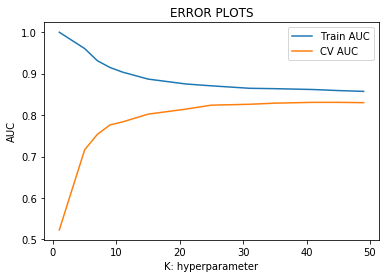

In [15]:
optimal_k = neighbors[AUC_CV.index(max(AUC_CV))]
print("The optimal number of neighbors: " + str(optimal_k))

plt.plot(neighbors, AUC_Train, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,train_auc - train_auc_std,train_auc - train_auc_std,alpha=0.2,color='darkblue')

plt.plot(neighbors, AUC_CV, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [16]:
import itertools
def confusionMatrixPlot(YTest, predTest):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(YTest, predTest)
    plt.imshow(cnf_matrix,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(YTest))) # length of classes
    class_labels = ['0','1']
    tick_marks
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    # plotting text value inside cells
    thresh = cnf_matrix.max() / 2.
    for i,j in itertools.product(range(cnf_matrix.shape[0]),range(cnf_matrix.shape[1])):
        plt.text(j,i,format(cnf_matrix[i,j],'d'),horizontalalignment='center',color='black' if cnf_matrix[i,j] >thresh else 'black')
    plt.show()

#### Testing with Test data

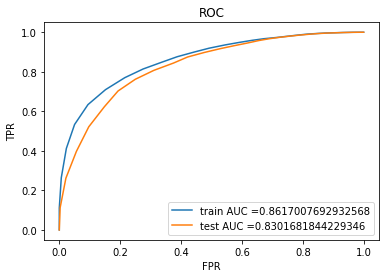

In [17]:
from sklearn.metrics import roc_curve, auc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
model= KNeighborsClassifier(n_neighbors= optimal_k)
model.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

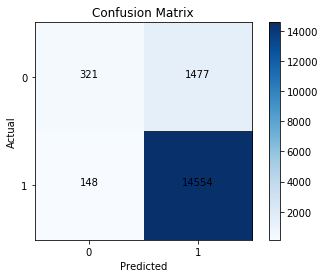

In [18]:
#Confusion matrix for BOW 
confusionMatrixPlot(y_test,model.predict(X_test_bow))

## [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [48]:
neighbors = [1, 5, 7, 9, 11, 15, 21, 25, 31, 35,41, 45, 49]

# empty list that will hold cv scores
cv_scores = []
AUC_Train = []
AUC_CV = []

# vectorising reviews
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500)
vectorizer.fit(X_train) 

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
X_train_tfidf = preprocessing.normalize(X_train_tfidf)

X_cv_tfidf = vectorizer.transform(X_cv)
X_cv_tfidf = preprocessing.normalize(X_cv_tfidf)

X_test_tfidf = vectorizer.transform(X_test)
X_test_tfidf = preprocessing.normalize(X_test_tfidf)

for k in neighbors:
    print("-------------------------k="+str(k)+"-------------------------")
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train_tfidf, y_train)
    predTrain = knn.predict_proba(X_train_tfidf)[:,1]
    predCV = knn.predict_proba(X_cv_tfidf)[:,1]
    
    auc = roc_auc_score(y_train,predTrain)
    #print('AUC for Train: %.3f' % auc1)
    AUC_Train.append(auc)
    
    auc = roc_auc_score(y_cv, predCV)
    #print('AUC for Test: %.3f' % auc)
    AUC_CV.append(auc)


-------------------------k=1-------------------------
-------------------------k=5-------------------------
-------------------------k=7-------------------------
-------------------------k=9-------------------------
-------------------------k=11-------------------------
-------------------------k=15-------------------------
-------------------------k=21-------------------------
-------------------------k=25-------------------------
-------------------------k=31-------------------------
-------------------------k=35-------------------------
-------------------------k=41-------------------------
-------------------------k=45-------------------------
-------------------------k=49-------------------------


The optimal number of neighbors: 49


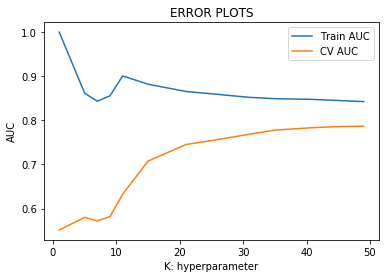

In [49]:
# Train vs CV AUC plot
optimal_k = neighbors[AUC_CV.index(max(AUC_CV))] #clf.best_params_['n_neighbors']
print("The optimal number of neighbors: " + str(optimal_k))

plt.plot(neighbors, AUC_Train, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(neighbors, AUC_CV, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

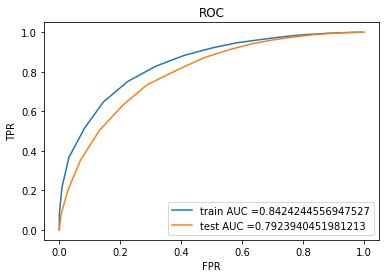

In [50]:
from sklearn.metrics import roc_curve, auc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
model= KNeighborsClassifier(n_neighbors= optimal_k)
model.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

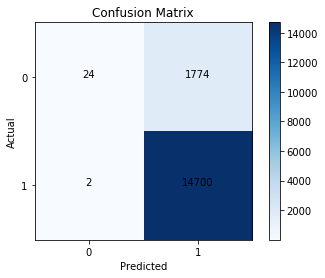

In [51]:
#Confusion matrix for BOW 
confusionMatrixPlot(y_test,model.predict(X_test_tfidf))

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [24]:
# Train your own Word2Vec model using your own text corpus
def sentenceSplit(data):
    list_of_sentance=[]
    for sentance in data:
        list_of_sentance.append(sentance.split())
    return list_of_sentance

In [25]:
# this line of code trains your w2v model on the give list of sentances
list_of_sentance_train = sentenceSplit(X_train)
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=150, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [26]:
def avgW2V(list_of_sentance,W2VModel):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(150) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in W2VModel:
                vec = W2VModel.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

#### Vectorizing Train and Test data

In [27]:
# Training Data
X_train_w2v = avgW2V(list_of_sentance_train, w2v_model)
X_train_w2v = preprocessing.normalize(X_train_w2v)


# cv data
list_of_sentance_cv = sentenceSplit(X_cv)
X_cv_w2v = avgW2V(list_of_sentance_cv, w2v_model)
X_cv_w2v = preprocessing.normalize(X_cv_w2v)


# Test Data
list_of_sentance_test = sentenceSplit(X_test)
X_test_w2v = avgW2V(list_of_sentance_test, w2v_model)
X_test_w2v = preprocessing.normalize(X_test_w2v)

100%|██████████| 16500/16500 [00:06<00:00, 2599.69it/s]


In [29]:
# myList = list(range(0,50))
neighbors = neighbors = [1, 5, 7, 9, 11, 15, 21, 25, 31, 35,41, 45, 49] # list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []
AUC_Train = []
AUC_CV = []

for k in neighbors:
    print("-------------------------k="+str(k)+"-------------------------")
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train_w2v, y_train)
    predTrain = knn.predict_proba(X_train_w2v)[:,1]
    predCV = knn.predict_proba(X_cv_w2v)[:,1]
    
    auc = roc_auc_score(y_train,predTrain)
    #print('AUC for Train: %.3f' % auc1)
    AUC_Train.append(auc)
    
    auc = roc_auc_score(y_cv, predCV)
    #print('AUC for Test: %.3f' % auc)
    AUC_CV.append(auc)


-------------------------k=1-------------------------
-------------------------k=5-------------------------
-------------------------k=7-------------------------
-------------------------k=9-------------------------
-------------------------k=11-------------------------
-------------------------k=15-------------------------
-------------------------k=21-------------------------
-------------------------k=25-------------------------
-------------------------k=31-------------------------
-------------------------k=35-------------------------
-------------------------k=41-------------------------
-------------------------k=45-------------------------
-------------------------k=49-------------------------


The optimal number of neighbors: 49


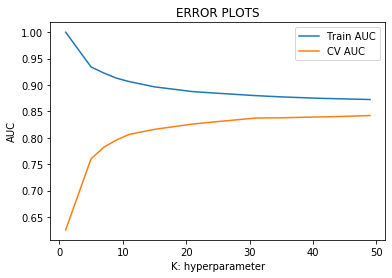

In [30]:
# Train vs CV AUC plot
optimal_k = neighbors[AUC_CV.index(max(AUC_CV))] #clf.best_params_['n_neighbors']
print("The optimal number of neighbors: " + str(optimal_k))

plt.plot(neighbors, AUC_Train, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(neighbors, AUC_CV, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

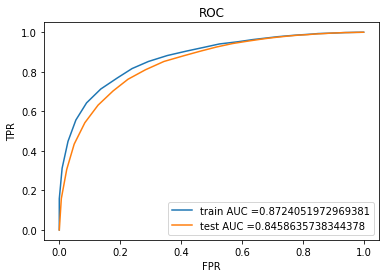

In [31]:
# Testing with test data
from sklearn.metrics import roc_curve, auc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
model= KNeighborsClassifier(n_neighbors= optimal_k)
model.fit(X_train_w2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_w2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_w2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

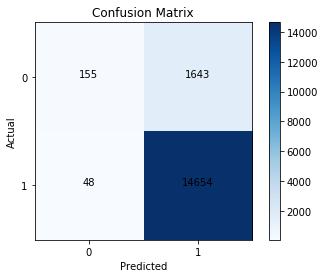

In [32]:
#Confusion matrix for AvgW2V
confusionMatrixPlot(y_test,model.predict(X_test_w2v))

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [33]:
# Vectorization of train and test review
vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=500)
vectorizer.fit(X_train)

# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in cv text
sent_of_cv = []
for sent in X_cv:
    sent_of_cv.append(sent.split()) 

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split()) 

In [34]:
# TFIDF-Word2Vec for training data.
tfidf_feat = vectorizer.get_feature_names()
X_train_tfidf = vectorizer.transform(X_train)
X_train_tfidf_AW2V = []; 
row=0;
for sent in tqdm(sent_of_train): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 22445/22445 [00:55<00:00, 403.60it/s]


In [35]:
# TFIDF-Word2Vec for training data.
tfidf_feat = vectorizer.get_feature_names()
X_cv_tfidf = vectorizer.transform(X_cv)
X_cv_tfidf_AW2V = []; 
row=0;
for sent in tqdm(sent_of_cv): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_cv_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_cv_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 11055/11055 [00:29<00:00, 369.34it/s]


In [36]:
# TFIDF-Word2Vec for test data .
from tqdm import tqdm

X_test_tfidf_AW2V = []; 
X_test_tfidf = vectorizer.transform(X_test)
row=0;
for sent in tqdm(sent_of_test): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 16500/16500 [00:35<00:00, 465.06it/s]


In [42]:
X_train_tfidf_AW2V = preprocessing.normalize(X_train_tfidf_AW2V)
X_test_tfidf_AW2V = preprocessing.normalize(X_test_tfidf_AW2V)
X_cv_tfidf_AW2V = preprocessing.normalize(X_cv_tfidf_AW2V)

In [43]:
# myList = list(range(0,50))
# neighbors = list(filter(lambda x: x % 2 != 0, myList))

neighbors = neighbors = [1, 5, 7, 9, 11, 15, 21, 25, 31, 35,41, 45, 49]
# empty list that will hold cv scores
cv_scores = []
AUC_Train = []
AUC_CV = []

for k in neighbors:
    print("-------------------------k="+str(k)+"-------------------------")
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train_tfidf_AW2V, y_train)
    predTrain = knn.predict_proba(X_train_tfidf_AW2V)[:,1]
    predCV = knn.predict_proba(X_cv_tfidf_AW2V)[:,1]
    
    auc = roc_auc_score(y_train,predTrain)
    #print('AUC for Train: %.3f' % auc1)
    AUC_Train.append(auc)
    
    auc = roc_auc_score(y_cv, predCV)
    #print('AUC for Test: %.3f' % auc)
    AUC_CV.append(auc)


-------------------------k=1-------------------------
-------------------------k=5-------------------------
-------------------------k=7-------------------------
-------------------------k=9-------------------------
-------------------------k=11-------------------------
-------------------------k=15-------------------------
-------------------------k=21-------------------------
-------------------------k=25-------------------------
-------------------------k=31-------------------------
-------------------------k=35-------------------------
-------------------------k=41-------------------------
-------------------------k=45-------------------------
-------------------------k=49-------------------------


The optimal number of neighbors: 49


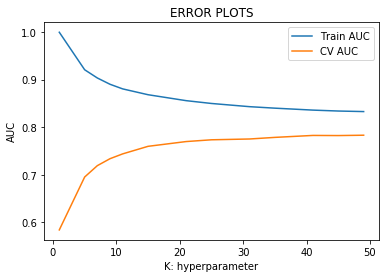

In [44]:
# Train vs CV AUC plot
optimal_k = neighbors[AUC_CV.index(max(AUC_CV))] #clf.best_params_['n_neighbors']
print("The optimal number of neighbors: " + str(optimal_k))

plt.plot(neighbors, AUC_Train, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(neighbors, AUC_CV, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

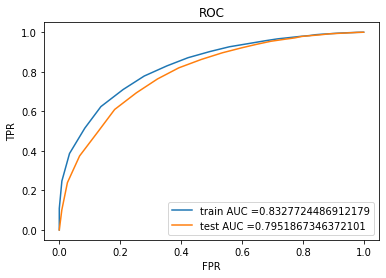

In [45]:
# Testing with test data
from sklearn.metrics import roc_curve, auc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
model= KNeighborsClassifier(n_neighbors= optimal_k)
model.fit(X_train_tfidf_AW2V, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_tfidf_AW2V)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_tfidf_AW2V)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

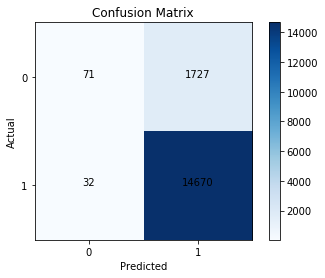

In [46]:
#Confusion matrix for AvgW2V
confusionMatrixPlot(y_test, model.predict(X_test_tfidf_AW2V))

## [5.2] Applying KNN kd-tree

In [9]:
#Forming separate datafrmae
Dataset = pd.DataFrame(
    {'Review': preprocessed_reviews,
     'Score': reviewDF['Score'][:50000],
    })
X= Dataset.Review.values
Y= Dataset.Score.values

In [10]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(22445,) (22445,)
(11055,) (11055,)
(16500,) (16500,)


### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [55]:
neighbors = [1, 5, 7, 9, 11, 15, 21, 25, 31, 35,41, 45, 49]

# empty list that will hold cv scores
cv_scores = []
AUC_Train = []
AUC_CV = []

# vectorising reviews
vectorizer = CountVectorizer(ngram_range=(1,2), max_features=500)
vectorizer.fit(X_train) 

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_train_bow = preprocessing.normalize(X_train_bow)

X_cv_bow = vectorizer.transform(X_cv)
X_cv_bow = preprocessing.normalize(X_cv_bow)

X_test_bow = vectorizer.transform(X_test)
X_test_bow = preprocessing.normalize(X_test_bow)

for k in neighbors:
    print("-------------------------k="+str(k)+"-------------------------")
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'kd_tree')

    knn.fit(X_train_bow, y_train)
    predTrain = knn.predict_proba(X_train_bow)[:,1]
    predCV = knn.predict_proba(X_cv_bow)[:,1]
    
    auc = roc_auc_score(y_train,predTrain)
    #print('AUC for Train: %.3f' % auc1)
    AUC_Train.append(auc)
    
    auc = roc_auc_score(y_cv, predCV)
    #print('AUC for Test: %.3f' % auc)
    AUC_CV.append(auc)


-------------------------k=1-------------------------
-------------------------k=5-------------------------
-------------------------k=7-------------------------
-------------------------k=9-------------------------
-------------------------k=11-------------------------
-------------------------k=15-------------------------
-------------------------k=21-------------------------
-------------------------k=25-------------------------
-------------------------k=31-------------------------
-------------------------k=35-------------------------
-------------------------k=41-------------------------
-------------------------k=45-------------------------
-------------------------k=49-------------------------


The optimal number of neighbors: 49


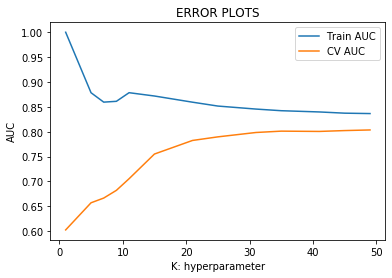

In [56]:
# Train vs CV AUC plot
optimal_k = neighbors[AUC_CV.index(max(AUC_CV))] #clf.best_params_['n_neighbors']
print("The optimal number of neighbors: " + str(optimal_k))

plt.plot(neighbors, AUC_Train, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(neighbors, AUC_CV, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

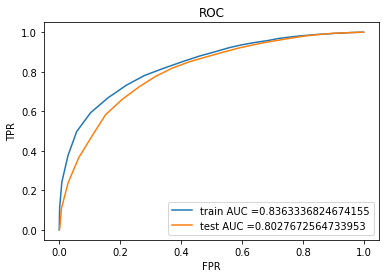

In [57]:
# Testing with test data
from sklearn.metrics import roc_curve, auc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
model= KNeighborsClassifier(n_neighbors= optimal_k, algorithm = 'kd_tree')
model.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

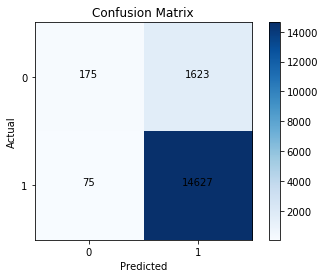

In [61]:
#Confusion matrix
confusionMatrixPlot(y_test, model.predict(X_test_bow))

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [67]:
neighbors = [1, 5, 7, 9, 11, 15, 21, 25, 31, 35,41, 45, 49]

# empty list that will hold cv scores
cv_scores = []
AUC_Train = []
AUC_CV = []

# vectorising reviews
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500)
vectorizer.fit(X_train) 

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
X_train_tfidf = preprocessing.normalize(X_train_tfidf)

X_cv_tfidf = vectorizer.transform(X_cv)
X_cv_tfidf = preprocessing.normalize(X_cv_tfidf)

X_test_tfidf = vectorizer.transform(X_test)
X_test_tfidf = preprocessing.normalize(X_test_tfidf)


for k in neighbors:
    print("-------------------------k="+str(k)+"-------------------------")
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'kd_tree')

    knn.fit(X_train_tfidf, y_train)
    predTrain = knn.predict_proba(X_train_tfidf)[:,1]
    predCV = knn.predict_proba(X_cv_tfidf)[:,1]
    
    auc = roc_auc_score(y_train,predTrain)
    #print('AUC for Train: %.3f' % auc1)
    AUC_Train.append(auc)
    
    auc = roc_auc_score(y_cv, predCV)
    #print('AUC for Test: %.3f' % auc)
    AUC_CV.append(auc)


-------------------------k=1-------------------------
-------------------------k=5-------------------------
-------------------------k=7-------------------------
-------------------------k=9-------------------------
-------------------------k=11-------------------------
-------------------------k=15-------------------------
-------------------------k=21-------------------------
-------------------------k=25-------------------------
-------------------------k=31-------------------------
-------------------------k=35-------------------------
-------------------------k=41-------------------------
-------------------------k=45-------------------------
-------------------------k=49-------------------------


The optimal number of neighbors: 49


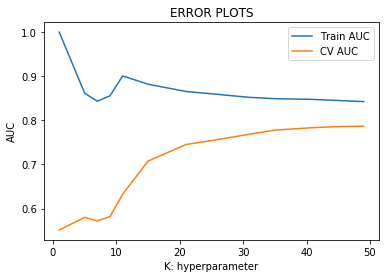

In [68]:
# Train vs CV AUC plot
optimal_k = neighbors[AUC_CV.index(max(AUC_CV))] #clf.best_params_['n_neighbors']
print("The optimal number of neighbors: " + str(optimal_k))

plt.plot(neighbors, AUC_Train, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(neighbors, AUC_CV, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

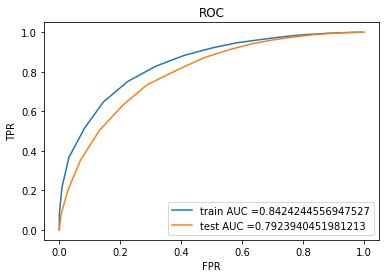

In [69]:
from sklearn.metrics import roc_curve, auc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
model= KNeighborsClassifier(n_neighbors= optimal_k, algorithm = 'kd_tree')
model.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

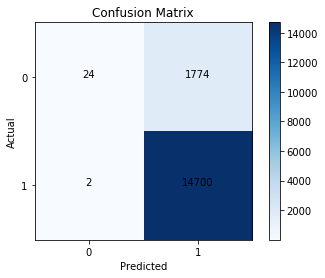

In [70]:
#Confusion matrix for BOW 
confusionMatrixPlot(y_test,model.predict(X_test_tfidf))

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 7</font>

In [71]:
# Train your own Word2Vec model using your own text corpus
def sentenceSplit(data):
    list_of_sentance=[]
    for sentance in data:
        list_of_sentance.append(sentance.split())
    return list_of_sentance

In [72]:
# this line of code trains your w2v model on the give list of sentances
list_of_sentance_train = sentenceSplit(X_train)
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=150, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [73]:
def avgW2V(list_of_sentance,W2VModel):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(150) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in W2VModel:
                vec = W2VModel.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

#### Vectorizing Train and Test data

In [74]:
# Training Data
X_train_w2v = avgW2V(list_of_sentance_train, w2v_model)
X_train_w2v = preprocessing.normalize(X_train_w2v)

# cv data
list_of_sentance_cv = sentenceSplit(X_cv)
X_cv_w2v = avgW2V(list_of_sentance_cv, w2v_model)
X_cv_w2v = preprocessing.normalize(X_cv_w2v)

# Test Data
list_of_sentance_test = sentenceSplit(X_test)
X_test_w2v = avgW2V(list_of_sentance_test, w2v_model)
X_test_w2v = preprocessing.normalize(X_test_w2v)


100%|██████████| 16500/16500 [00:08<00:00, 1956.66it/s]


In [75]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []
AUC_Train = []
AUC_CV = []

for k in neighbors:
    print("-------------------------k="+str(k)+"-------------------------")
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'kd_tree')

    knn.fit(X_train_w2v, y_train)
    predTrain = knn.predict_proba(X_train_w2v)[:,1]
    predCV = knn.predict_proba(X_cv_w2v)[:,1]
    
    auc = roc_auc_score(y_train,predTrain)
    #print('AUC for Train: %.3f' % auc1)
    AUC_Train.append(auc)
    
    auc = roc_auc_score(y_cv, predCV)
    #print('AUC for Test: %.3f' % auc)
    AUC_CV.append(auc)

-------------------------k=1-------------------------
-------------------------k=3-------------------------
-------------------------k=5-------------------------
-------------------------k=7-------------------------
-------------------------k=9-------------------------
-------------------------k=11-------------------------
-------------------------k=13-------------------------
-------------------------k=15-------------------------
-------------------------k=17-------------------------
-------------------------k=19-------------------------
-------------------------k=21-------------------------
-------------------------k=23-------------------------
-------------------------k=25-------------------------
-------------------------k=27-------------------------
-------------------------k=29-------------------------
-------------------------k=31-------------------------
-------------------------k=33-------------------------
-------------------------k=35-------------------------
---------------

The optimal number of neighbors: 49


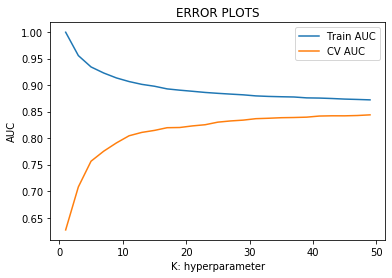

In [76]:
# Train vs CV AUC plot
optimal_k = neighbors[AUC_CV.index(max(AUC_CV))] #clf.best_params_['n_neighbors']
print("The optimal number of neighbors: " + str(optimal_k))

plt.plot(neighbors, AUC_Train, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(neighbors, AUC_CV, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

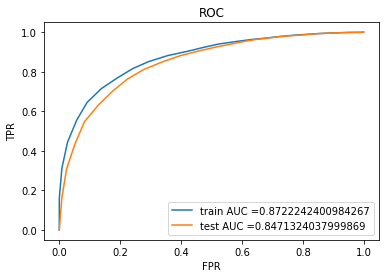

In [77]:
# Testing with test data
from sklearn.metrics import roc_curve, auc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
model= knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm = 'kd_tree')
model.fit(X_train_w2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_w2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_w2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

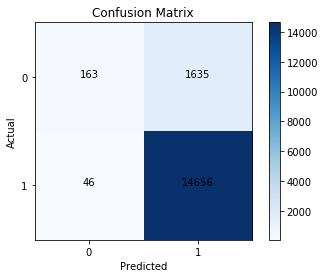

In [79]:
#Confusion matrix for AvgW2V
confusionMatrixPlot(y_test, model.predict(X_test_w2v))

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 8</font>

In [80]:
# Vectorization of train and test review
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500)
vectorizer.fit(X_train)

# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in cv text
sent_of_cv = []
for sent in X_cv:
    sent_of_cv.append(sent.split()) 

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split()) 

In [81]:
# TFIDF-Word2Vec for training data.
tfidf_feat = vectorizer.get_feature_names()
X_train_tfidf = vectorizer.transform(X_train)
X_train_tfidf_AW2V = []; 
row=0;
for sent in tqdm(sent_of_train): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 22445/22445 [01:00<00:00, 373.37it/s]


In [82]:
# TFIDF-Word2Vec for training data.
tfidf_feat = vectorizer.get_feature_names()
X_cv_tfidf = vectorizer.transform(X_cv)
X_cv_tfidf_AW2V = []; 
row=0;
for sent in tqdm(sent_of_cv): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_cv_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
            
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_cv_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 11055/11055 [00:37<00:00, 298.20it/s]


In [83]:
# TFIDF-Word2Vec for test data .
from tqdm import tqdm

X_test_tfidf_AW2V = []; 
X_test_tfidf = vectorizer.transform(X_test)
row=0;
for sent in tqdm(sent_of_test): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 16500/16500 [00:43<00:00, 377.22it/s]


In [85]:
neighbors = [1, 5, 7, 9, 11, 15, 21, 25, 31, 35,41, 45, 49]

# empty list that will hold cv scores
cv_scores = []
AUC_Train = []
AUC_CV = []

for k in neighbors:
    print("-------------------------k="+str(k)+"-------------------------")
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'kd_tree')

    knn.fit(X_train_tfidf_AW2V, y_train)
    predTrain = knn.predict_proba(X_train_tfidf_AW2V)[:,1]
    predCV = knn.predict_proba(X_cv_tfidf_AW2V)[:,1]
    
    auc = roc_auc_score(y_train,predTrain)
    #print('AUC for Train: %.3f' % auc1)
    AUC_Train.append(auc)
    
    auc = roc_auc_score(y_cv, predCV)
    #print('AUC for Test: %.3f' % auc)
    AUC_CV.append(auc)


-------------------------k=1-------------------------
-------------------------k=5-------------------------
-------------------------k=7-------------------------
-------------------------k=9-------------------------
-------------------------k=11-------------------------
-------------------------k=15-------------------------
-------------------------k=21-------------------------
-------------------------k=25-------------------------
-------------------------k=31-------------------------
-------------------------k=35-------------------------
-------------------------k=41-------------------------
-------------------------k=45-------------------------
-------------------------k=49-------------------------


The optimal number of neighbors: 49


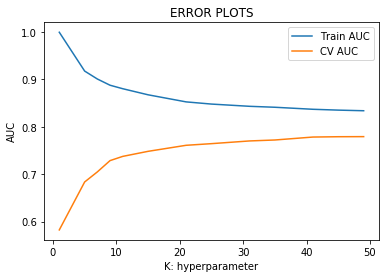

In [86]:
# Train vs CV AUC plot
optimal_k = neighbors[AUC_CV.index(max(AUC_CV))] #clf.best_params_['n_neighbors']
print("The optimal number of neighbors: " + str(optimal_k))

plt.plot(neighbors, AUC_Train, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(neighbors, AUC_CV, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

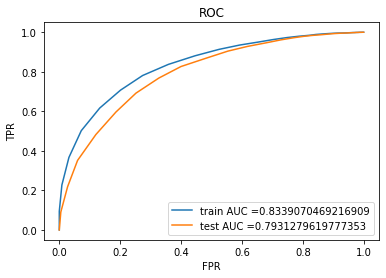

In [87]:
# Testing with test data
from sklearn.metrics import roc_curve, auc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
model= knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm = 'kd_tree')
model.fit(X_train_tfidf_AW2V, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_tfidf_AW2V)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_tfidf_AW2V)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

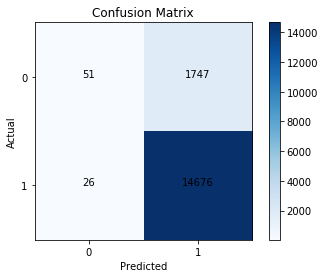

In [88]:
#Confusion matrix for AvgW2V
confusionMatrixPlot(y_test, model.predict(X_test_tfidf_AW2V))

# [6] Conclusions

In [89]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]

x.add_row(["BOW", "Brute", 41, 0.83])
x.add_row(["TFIDF", "Brute", 49, 0.79])
x.add_row(["Avg W2V", "Brute", 49, 0.84])
x.add_row(["TFIDF_Avg W2V", "Brute", 49, 0.79])
x.add_row(["BOW", "KD Tree", 49, 0.80])
x.add_row(["TFIDF", "KD Tree", 49, 0.79])
x.add_row(["Avg W2V", "KD Tree", 49, 0.84])
x.add_row(["TFIDF_Avg W2V", "KD Tree", 49, 0.79])

print(x)

+---------------+---------+----------------+------+
|   Vectorizer  |  Model  | Hyperparameter | AUC  |
+---------------+---------+----------------+------+
|      BOW      |  Brute  |       41       | 0.83 |
|     TFIDF     |  Brute  |       49       | 0.79 |
|    Avg W2V    |  Brute  |       49       | 0.84 |
| TFIDF_Avg W2V |  Brute  |       49       | 0.79 |
|      BOW      | KD Tree |       49       | 0.8  |
|     TFIDF     | KD Tree |       49       | 0.79 |
|    Avg W2V    | KD Tree |       49       | 0.84 |
| TFIDF_Avg W2V | KD Tree |       49       | 0.79 |
+---------------+---------+----------------+------+
